In [1]:
import numpy as np, pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn

from datetime import datetime

plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (8, 4)


<ipython-input-1-ecf154012815>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
import tensorflow as tf 
from tensorflow import keras

# global temperature anomaly with nn

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/msssivadas10/climate-ml/main/data/GLB.Ts%2BdSST.csv', 
                 header=0, na_values='***', usecols=range(13), skiprows=1)

years = df.pop('Year').values
df = pd.DataFrame({
                    'Year' : [datetime(year, month, 1) for year in years for month in range(1, 13)], 
                    'Temperature Anomaly (degC)': df.values.flatten()
                 })
df = df.dropna()

df.tail()

,Year,Temperature Anomaly (degC)
1709,2022-06-01,0.92
1710,2022-07-01,0.93
1711,2022-08-01,0.95
1712,2022-09-01,0.89
1713,2022-10-01,0.96


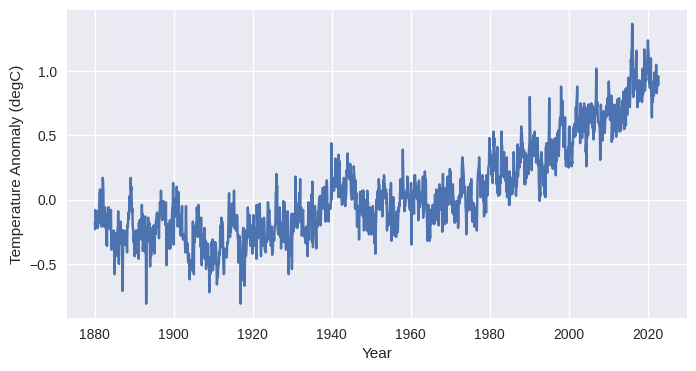

In [4]:
_ = sbn.lineplot(df, x='Year', y='Temperature Anomaly (degC)')

In [5]:
signal = df['Temperature Anomaly (degC)'].values

train_split, test_split = int(0.7*signal.shape[0]), int(0.9*signal.shape[0])

train_signal = signal[:train_split]
val_signal   = signal[train_split:test_split]
test_signal  = signal[test_split:] 

In [6]:
# shift, scale = train_signal.mean(), train_signal.std()

signal_max, signal_min = signal.max(), signal.min()
# NOTE: scaling the signal to range [0,1] is not logical as the signal may not be bounded. but this NN makes
# good predictions only with scaling, unfortunately :(

shift, scale = signal_min, signal_max - signal_min

train_signal = (train_signal - shift) / scale
val_signal   = (val_signal - shift) / scale
test_signal  = (test_signal - shift) / scale


In [7]:
def make_dataset(series, lookback=1):

    x, y = [], []
    for i in range(lookback, len(series)):
        x.append( series[i-lookback:i] )
        y.append( series[i] )
    return np.array(x)[:,:,None], np.array(y)


lookback = 6

train_x, train_y = make_dataset(train_signal, lookback)
val_x, val_y     = make_dataset(val_signal, lookback)
test_x, test_y   = make_dataset(test_signal, lookback)

In [8]:
model = keras.models.Sequential()

model.add( keras.layers.LSTM(6, input_shape=(lookback, 1), return_sequences=False) )
model.add( keras.layers.Dense(1) )

model.compile( loss='mean_squared_error', optimizer='adam' )

In [9]:
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=100, verbose=0)

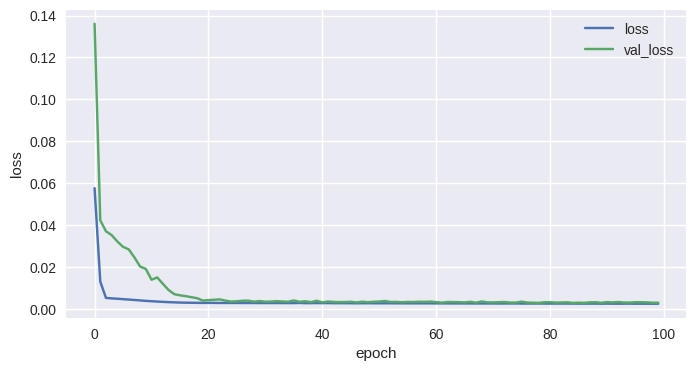

In [15]:
hist = dict(epoch=history.epoch, **history.history)

_ = sbn.lineplot(hist, x='epoch', y='loss', label='loss')
_ = sbn.lineplot(hist, x='epoch', y='val_loss', label='val_loss')

plt.savefig('training-history.eps', format='eps')

In [11]:
train_predict = model.predict(train_x) # predictions for training set

val_predict   = model.predict(val_x)   # predictions for validation set

test_predict  = model.predict(test_x)  # predictions for test set

6/6 [==============================] - 0s 3ms/step


In [12]:
predict = np.empty_like(signal)
predict[:] = np.nan

dset_id = np.empty_like(signal, dtype='object')
dset_id[:] = np.nan

predict[lookback:train_split] = train_predict.flatten()
dset_id[lookback:train_split] = 0

predict[train_split+lookback:test_split] = val_predict.flatten()
dset_id[train_split+lookback:test_split] = 1

predict[test_split+lookback:] = test_predict.flatten()
dset_id[test_split+lookback:] = 2


predict = predict*scale + shift

df['predicted'] = predict
df['data'] = dset_id
df['data'] = df['data'].map({0:'training',1:'validation',2:'testing'})

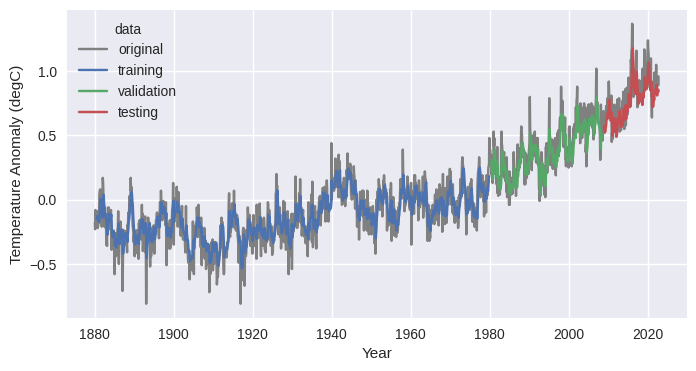

In [16]:
_ = sbn.lineplot(df, x='Year', y='Temperature Anomaly (degC)', color='gray', label='original')
_ = sbn.lineplot(df, x='Year', y='predicted', hue='data')

plt.savefig('data-predict.eps', format='eps')

In [14]:
past = []
for value in signal[-lookback:]:
    past.append([value])

scaled_past = (np.array(past) - shift) / scale

predicted_value = model.predict(scaled_past[None,:,:]).flatten()
predicted_value = predicted_value[0]*scale + shift # re-scale to original range

print(f"2022-10-01: {signal[-1]} deg C")
print(f"2022-11-01: {predicted_value:.2f} deg C (predicted)")

1/1 [==============================] - 0s 27ms/step
2022-10-01: 0.96 deg C
2022-11-01: 0.86 deg C (predicted)
